Install some baseline packages:

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Read in our input file:

In [2]:
sf_incidents <- read.csv("sanfrancisco_incidents_summer_2014.csv")

We're only interested in criminal statistics for this exercise, so we'll delete anything classified in the non-criminal category offhand. We'll also drop some of the columns from the data that we do keep, to help with wrangling:

In [3]:
crimOnly <- subset(sf_incidents, Category != "NON-CRIMINAL", select = c(Category, Descript, DayOfWeek, Time, PdDistrict, Resolution))

Order the days of the week in Mon-Sun order to make sure everything is presented consistently:

In [4]:
crimOnly$DayOfWeek <- ordered(crimOnly$DayOfWeek, levels = c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

Now let's get a count of crime categories, aggregated by the day of the week:

In [5]:
crimGroup <- crimOnly %>% group_by(Category,DayOfWeek) %>% count() %>% ungroup()

A sample of the aggregated data (the full dataset is still too unwieldy to display at this point):

In [6]:
head(crimGroup, n=10)

Category,DayOfWeek,n
<fct>,<ord>,<int>
ARSON,Monday,7
ARSON,Tuesday,8
ARSON,Wednesday,13
ARSON,Thursday,8
ARSON,Friday,5
ARSON,Saturday,10
ARSON,Sunday,12
ASSAULT,Monday,406
ASSAULT,Tuesday,356


A graph showing all crime categories that had an aggregate of > 200 instances over the time period in our dataset; there are many categories that only had a few occurrences, so we'll ignore those.   (Note:  The fancy formula in scale_y_continuous is to force the y-axis to integers since that's what we're dealing with.):

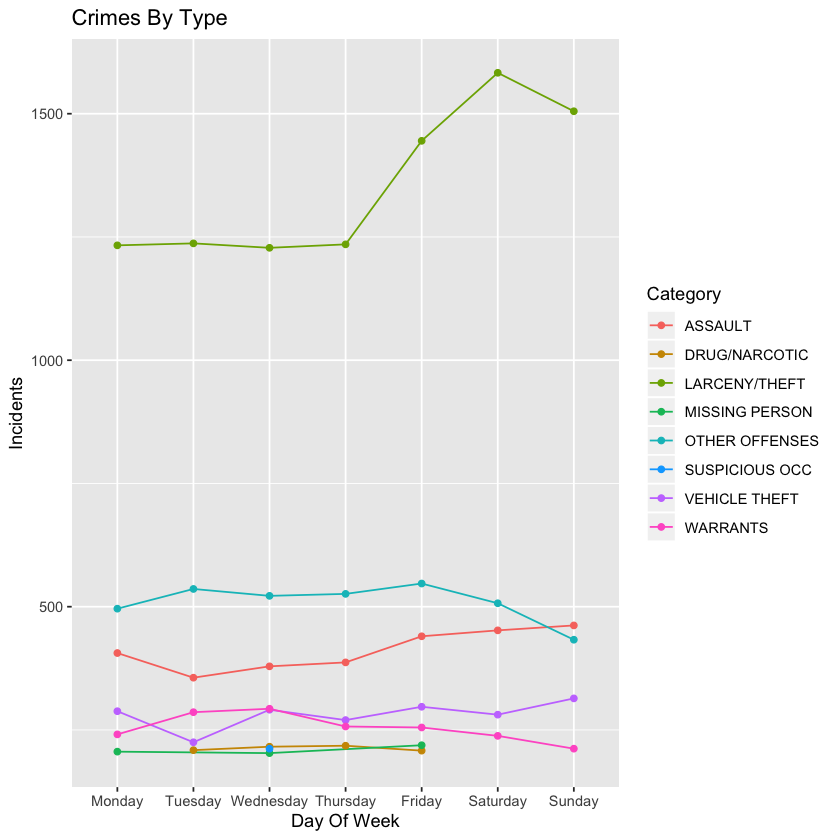

In [7]:
ggplot(crimGroup[crimGroup$n > 200,], aes(DayOfWeek, n, group=Category, col=Category)) + geom_line() + geom_point() + labs(x="Day Of Week", y="Incidents", title="Crimes By Type") + scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))

Clearly Larceny/theft is the biggest problem here, so we'll turn our attention to that (note here that we're going back to our first cleaned dataset to avoid introducing any compound errors):

In [8]:
larceny <- subset(crimOnly, Category == "LARCENY/THEFT", select = c(Category, Descript, DayOfWeek, Time, PdDistrict, Resolution))

Now that we've found the category with the highest occurence, let's split it out into its atomic types ("Descript" in the original dataset):

In [9]:
larcenyByType <- larceny %>% group_by(Descript,DayOfWeek) %>% count() %>% ungroup()

Plot a graph of all of the types of larceny with more than 50 occurrences reported:

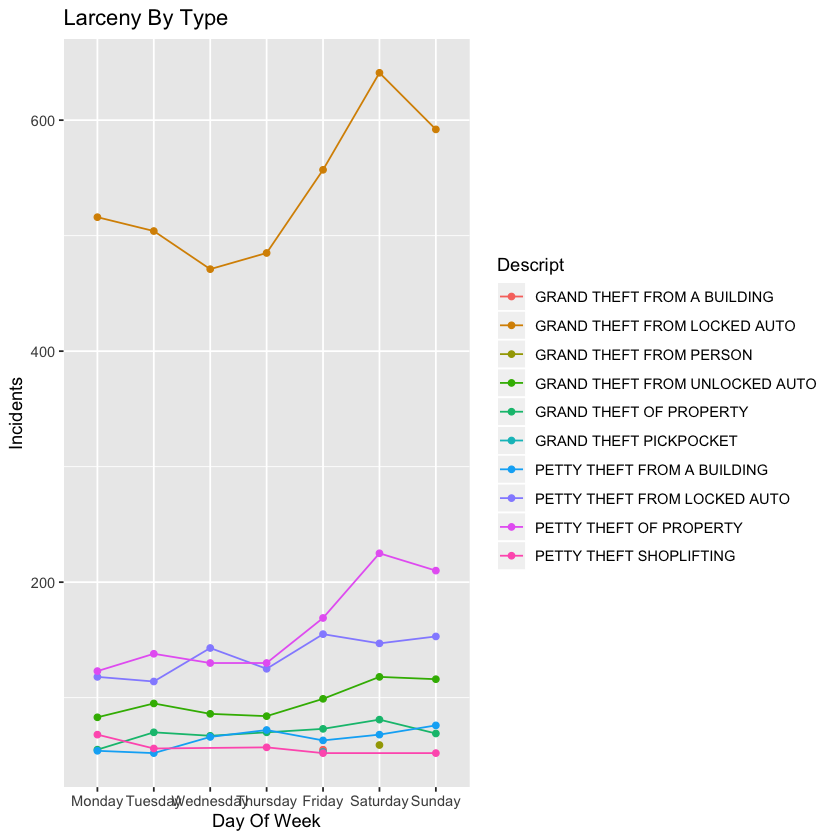

In [10]:
ggplot(larcenyByType[larcenyByType$n > 50,], aes(DayOfWeek, n, group=Descript, col=Descript)) + geom_line() + geom_point() + labs(x="Day Of Week", y="Incidents", title="Larceny By Type")

Of all the types of larceny reported, Grand Theft From A Locked Auto is far and away the most common.  We'll focus on that from here on out.

In [11]:
lockedAuto <- subset(larceny, Descript == "GRAND THEFT FROM LOCKED AUTO")

There are a few potentially interesting things we can try to correlate here.  First, let's aggregate by police district:

In [12]:
lockedAutoByDist <- lockedAuto %>% group_by(PdDistrict, DayOfWeek) %>% count() %>% ungroup()

Time of day is also an interesting thing to consider, so we'll generate that next:

In [20]:
lockedAutoByTime <- lockedAuto %>% group_by(Time, DayOfWeek) %>% count() %>% ungroup

There is also a spike in incidents over the weekend (Friday, Saturday, Sunday), so let's pull those out and aggegate by day:

In [14]:
tmpWknd <- subset(lockedAuto, (DayOfWeek=="Friday"|DayOfWeek=="Saturday"|DayOfWeek=="Sunday"))
lockedAutoWknd <- tmpWknd %>% group_by(Time, DayOfWeek) %>% count() %>% ungroup()

The cell below needs work.  It may be using an older version of ggplot that no longer supports this.

In [15]:
#ggplot() + geom_line() + geom_point(lockedAutoByDist[lockedAutoByDist$n > 50,], aes(DayOfWeek, n, group=PdDistrict, col=PdDistrict)) + geom_point(lockedAuto, aes(DayOfWeek, n, group=PdDistrict, col=PdDistrict))

Plot by district:

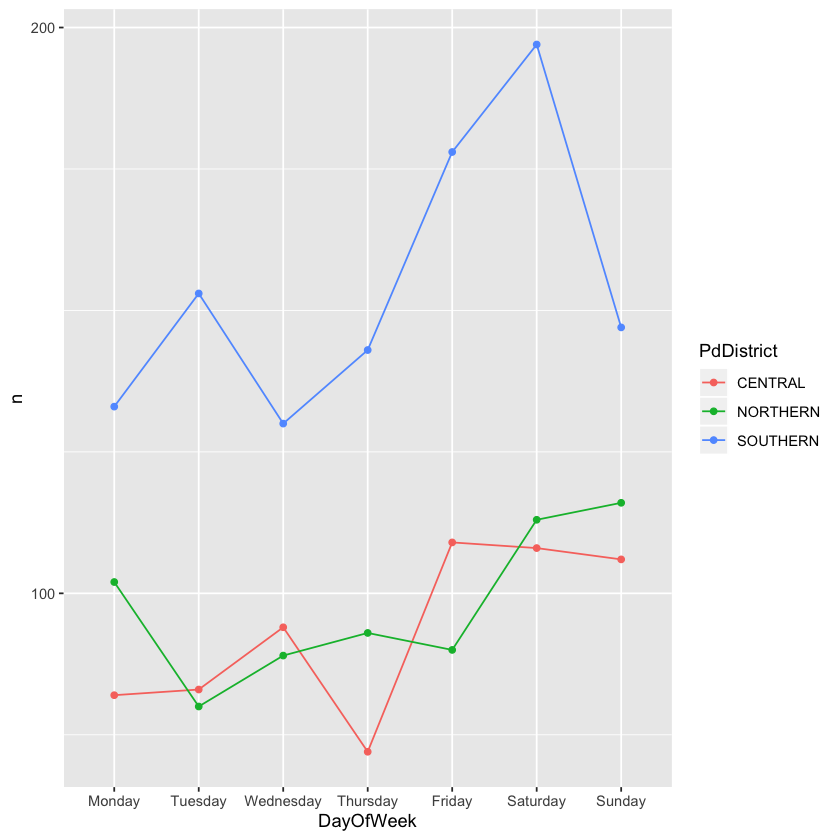

In [16]:
ggplot(lockedAutoByDist[lockedAutoByDist$n > 50,], aes(DayOfWeek, n, group=PdDistrict, col=PdDistrict)) + geom_line() + geom_point() + scale_y_continuous(breaks = seq(0, 2000, by=100), minor_breaks = seq(0,2000, by = 25))

Plot by time:

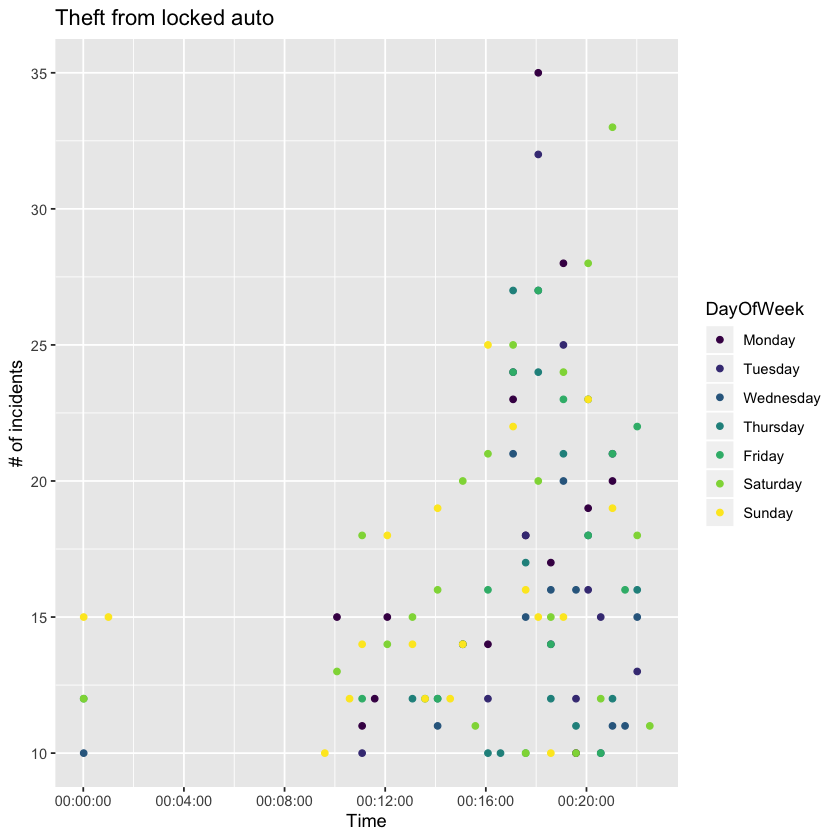

In [21]:
ggplot(lockedAutoByTime[lockedAutoByTime$n > 9,], aes(Time, n, col=DayOfWeek)) + labs(y="# of incidents", title="Theft from locked auto") + geom_point() + scale_x_time()

Plot by time only over the weekend days:

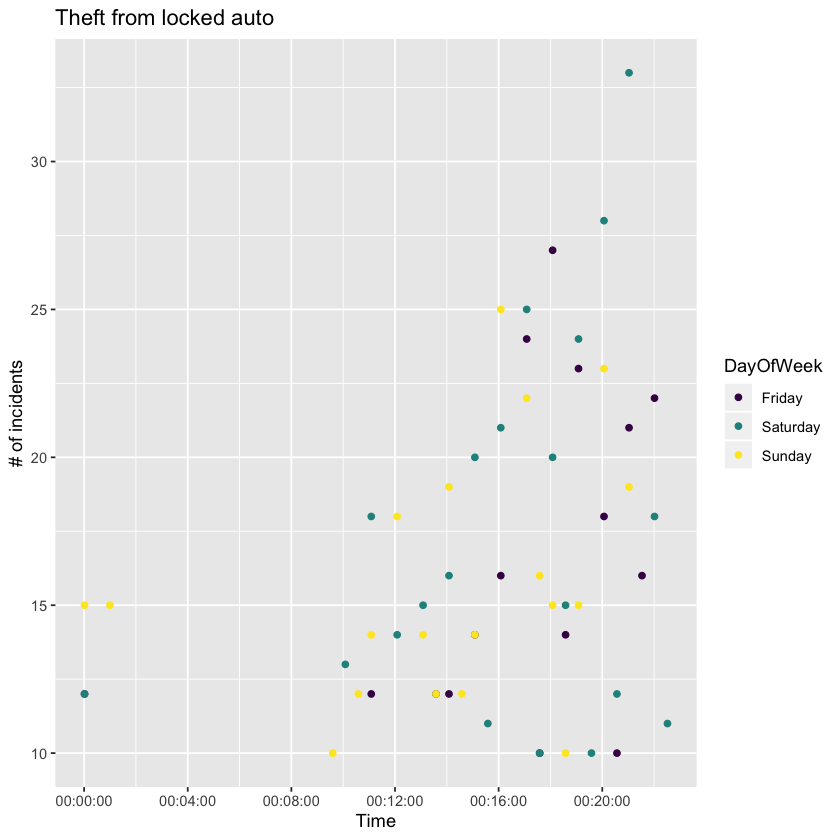

In [18]:
ggplot(lockedAutoWknd[lockedAutoWknd$n > 9,], aes(Time, n, col=DayOfWeek))+ labs(y="# of incidents", title="Theft from locked auto") + geom_point() + scale_x_time()